In [50]:
# import the necessary packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Softmax
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.backend import categorical_crossentropy
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import layers
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy

# from tensorflow.python.keras.models import Model
# from tensorflow.python.keras.layers import Flatten, Dense, Dropout
# from tensorflow.python.keras.applications import ResNet50
# from tensorflow.python.keras.models import Sequential

def get_layer_name(model, layer_id):
    layer = model.layers[layer_id]
    return layer.name

def define_model(numclasses, input_shape_x,pre_trained_model="resnet50"):
        #MERGING INPUTS AT DEPTH 6, AS ACCORDING TO https://www.azavea.com/blog/2019/08/30/transfer-learning-from-rgb-to-multi-band-imagery/
        #This corresponds to merging the outputs after conv2_block3_out

        print(f"Using Pre-trained {pre_trained_model} model")
        
        # parameters for CNN
        input_tensor = Input(shape=input_shape_x,name='input_x')

        # introduce a additional layer to get from bands to 3 input channels
        input_tensor = Conv2D(3, (1, 1))(input_tensor)      #TODO: CHECK THIS, Why (1,1)
        
        if pre_trained_model == "resnet50":
            RGB_base_model = keras.applications.ResNet50(include_top=False,
                                                              weights='imagenet',
                                                              input_shape=(100, 100, 3))
            
            xbands_base_model = keras.applications.ResNet50(include_top=False,
                                                     weights=None,
                                                     input_tensor=input_tensor)  #Ideally, this would be a resnet50 trained on the extra bands
            
            
            RGB_base_model.layers[0]._name = 'input_RGB'

            for layer in xbands_base_model.layers :
                layer._name = layer.name + str('_x')

            layer_name_1 = get_layer_name(RGB_base_model, 38)
            layer_name_2 = get_layer_name(xbands_base_model, 38)
            layer_name_3 = get_layer_name(xbands_base_model, 40)
                
            premerge_RGB_model =  Model(inputs=RGB_base_model.input, outputs=RGB_base_model.get_layer(layer_name_1).output)
            premerge_xbands_model = Model(inputs=xbands_base_model.input, outputs=xbands_base_model.get_layer(layer_name_2).output)
            merged_features = Add()([premerge_RGB_model.output, premerge_xbands_model.output])
            premerge_model = Model(inputs= [premerge_RGB_model.input, premerge_xbands_model.input],outputs = merged_features)
            return RGB_base_model, xbands_base_model
            postmerge_model = Model(inputs = xbands_base_model.get_layer(layer_name_3).input, outputs= xbands_base_model.output)
            full_output = postmerge_model(premerge_model.output)
            full_model = Model(inputs= [premerge_RGB_model.input, premerge_xbands_model.input], outputs= full_output)

            return full_model

In [51]:
a, b = define_model(4, (100,100,4))

Using Pre-trained resnet50 model


In [52]:
b.layers[40].name

'res3a_branch2a_x'

In [53]:
b.get_layer(b.layers[40].name).input

<tf.Tensor 'activation_1185/Relu:0' shape=(?, 25, 25, 256) dtype=float32>

In [2]:
import pdb
from collections import defaultdict
def load_and_process_csv(csv_path,train=True):
  df = pd.read_csv(csv_path)
  df = df.drop_duplicates()
  df = df[df[['0','1','2','3','4']].sum(axis=1) < 2] #Remove all rows with multiple labels
  if train:
    df['label'] = [i.split('/')[0] for i in df['paths']]
  else:
    df['label'] = [i.split('/')[3] for i in df['paths']]
  df = df[['paths','label']]

  df = df.sample(frac=1) #Shuffle rows
  return df

def convert_path(orig_path,path_type):
  if path_type == "train" :
    return '/'.join(['./project-canopy_data_RGB/',orig_path.split('/')[0],orig_path.split('/')[-1]]).replace('.tif','.png')

  if path_type == "test":
    return '/'.join(['./project-canopy_data_RGB/',orig_path.split('/')[3],orig_path.split('/')[-1]]).replace('.tif','.png')

#TODO: Check if this method of assigning labels is correct (VVIMP!!)
def df_to_data(df,df_type,balance_count=None):
  images = []
  labels = []
  label_counts = defaultdict(int)
  num_classes = len(set(df['label']))

  if balance_count is None:
     balance_count = len(df)
  
  for index,row in df.iterrows():
    label = row['label']
    if label_counts[label] >= balance_count:
      continue
    else:
      label_counts[label] += 1
    labels.append(label)
    path = row['paths']
    # if 'chips' 
    path = convert_path(path,df_type)
    img = cv2.imread(path)
    # pdb.set_trace()
    images.append(img)
    if len(labels) >= balance_count*num_classes: #Stop once we collect n =balance_count labels from each class
      break
  images = np.array(images, dtype="float") / 255.0
  return images,labels

def convert_labels(train_labels,test_labels):
  # pdb.set_trace()
  le = LabelEncoder()
  num_classes = len(set(train_labels))
  train_labels = le.fit_transform(train_labels)
  test_labels = le.transform(test_labels)
  trainY = np_utils.to_categorical(train_labels, num_classes)
  testY = np_utils.to_categorical(test_labels, num_classes)
  return trainY,testY,le

def get_labels_count(label_list):
  d = defaultdict(int)
  for label in label_list:
    d[label] += 1
  return d


def remove_class_imbalance(df,count_limit = None):
  l = []
  d = get_labels_count(df['label'])
  if count_limit == None:
    count_limit = min(d.values())

  curr_count = defaultdict(int)
  for index,row in df.iterrows():
    if curr_count[row['label']] >= count_limit:
      continue
    else:
      l.append(row)
      curr_count[row['label']] += 1
  return pd.DataFrame(l,columns = df.columns)


def get_class_weights_from_count(count_dict,le):
  class_weights = {}
  classes = le.classes_
  for i in range(len(classes)):
    class_weights[i] = count_dict[classes[i]]
  
  return class_weights







In [3]:
#DUMMY DATA PROCESSING(Randomly assign a label to each image, just to verify the training code working syntax)
import os
import cv2
import random
import pdb
from skimage import io

def read_data(folder_path):
  images  =[]
  labels = []
  for image_path in os.listdir(folder_path):
      full_path = os.path.join(folder_path,image_path)
      image = io.imread(full_path)
      images.append(image)
      labels.append(random.randint(0,1))
  
  return images,labels


def split_into_rgb_x(image):
  rgb = image[:,:,0:3]
  x = image[:,:,3:7]
  return rgb,x


def split_images_into_inputs(images):
  inputs_1,inputs_2 = [],[]
  for image in images:
    rgb,x = split_into_rgb_x(image)
    inputs_1.append(rgb)
    inputs_2.append(x)
  return np.array(inputs_1),np.array(inputs_2)



In [4]:
import matplotlib
matplotlib.use("Agg")
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import cv2
import os
import pandas as pd

# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
    width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
    horizontal_flip=True, fill_mode="nearest")





Using TensorFlow backend.


In [44]:
INIT_LR = 1e-4
BS = 16
EPOCHS = 1

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model = define_model(numclasses=4,input_shape_x=(100,100,4))

model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])

Using Pre-trained resnet50 model
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: activation_989/Relu:0


ValueError: Graph disconnected: cannot obtain value for tensor Tensor("input_x_10:0", shape=(?, 100, 100, 4), dtype=float32) at layer "input_x_x". The following previous layers were accessed without issue: []

In [ ]:
print("[INFO] training network for {} epochs...".format(EPOCHS))

trainX_rgb,trainX_x = split_images_into_inputs(trainX)
testX_rgb,testX_x = split_images_into_inputs(testX)



#WITHOUT AUGMENTATION FLOW
# H = model.fit({'x':trainX_x,'rgb':trainX_rgb},y=np.array(trainY),validation_data=([testX_x,testX_rgb],np.array(testY)),steps_per_epoch=len(trainX)//BS,epochs = EPOCHS)
H = model.fit({'input_x':trainX_x,'input_RGB':trainX_rgb},np.array(trainY),steps_per_epoch=len(trainX)//BS,epochs = EPOCHS)

# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1),
    predictions.argmax(axis=1), target_names=le.classes_))

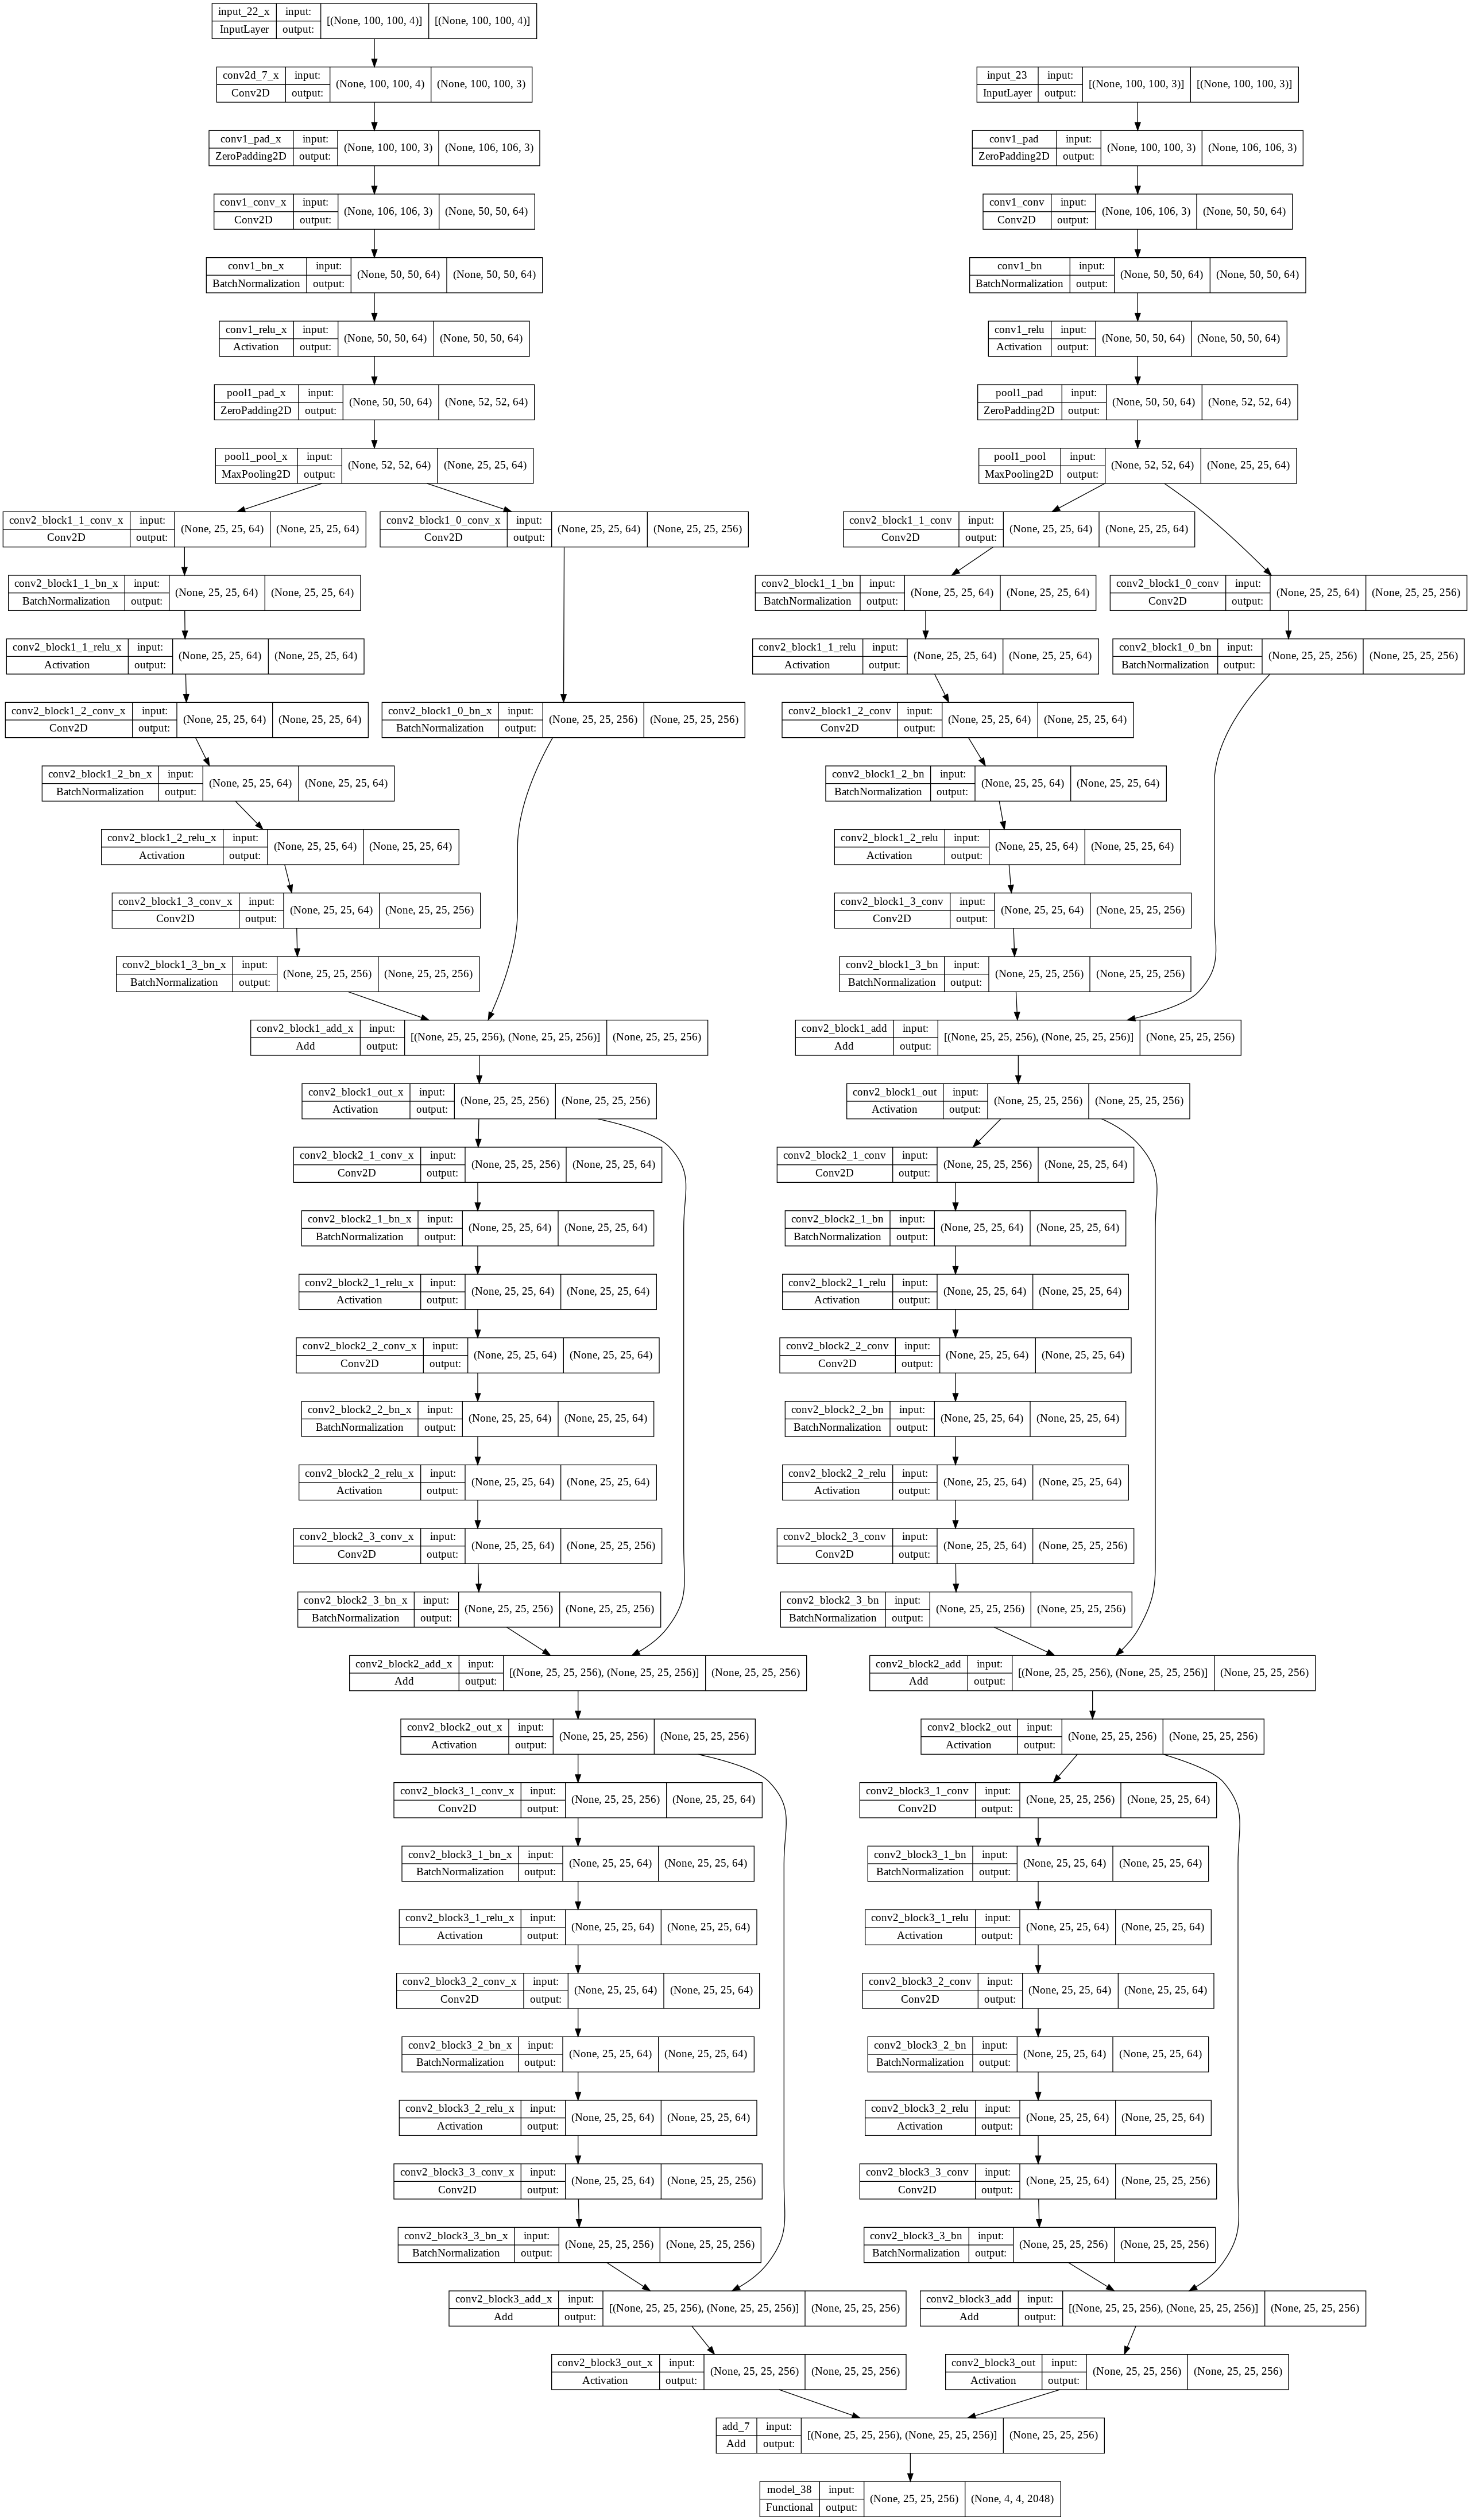

In [ ]:
#LOAD TRAINED MODEL
# model.summary()
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)



In [ ]:
#TRAINING DATA METRICS
print("TRAINING DATA METRICS")
predictions = model.predict(trainX, batch_size=BS)
print(classification_report(trainY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=le.classes_))

print("\n"*3)
#TESTING DATA METRICS
print("TESTING DATA METRICS")
predictions = model.predict(testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=le.classes_))

TRAINING DATA METRICS
                        precision    recall  f1-score   support

                   ISL       0.96      0.98      0.97      1000
Industrial_agriculture       1.00      0.98      0.99       814
                Mining       0.99      0.81      0.89       117
                 Roads       0.99      0.93      0.96       548
  Shifting_cultivation       0.98      0.91      0.94      1000
                  misc       0.89      0.98      0.93      1000

              accuracy                           0.95      4479
             macro avg       0.97      0.93      0.95      4479
          weighted avg       0.96      0.95      0.95      4479





TESTING DATA METRICS
                        precision    recall  f1-score   support

                   ISL       0.85      0.82      0.83       807
Industrial_agriculture       0.21      0.26      0.24        46
                Mining       0.33      0.14      0.20        21
                 Roads       0.31      0.30      0.30

In [ ]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

In [ ]:
%matplotlib inline
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, EPOCHS), normalize(np.array(H.history["loss"])), label="train_loss")
plt.plot(np.arange(0, EPOCHS), normalize(np.array(H.history["val_loss"])), label="val_loss")
plt.plot(np.arange(0, EPOCHS), H.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, EPOCHS), H.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()
# plt.savefig(args["plot"])

NameError: ignored

In [ ]:
model.save(f"/content/drive/MyDrive/Canopy/models/model_rgb_{EPOCHS}epochs")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Canopy/models/model_rgb_100epochs/assets


In [ ]:
H.history["val_loss"]

[2.528667449951172,
 0.678312361240387,
 0.7589249610900879,
 2.123173952102661,
 0.5486119985580444,
 0.6381982564926147,
 0.41850554943084717,
 0.41787296533584595,
 0.8696414232254028,
 0.43098723888397217]